In [ ]:
# usual imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


And yep, loading is indeed faster than using CSVs in this case

In [ ]:
with open('/content/gdrive/My Drive/Notebooks Colab/cleanDF.pickle', 'rb') as handle:
    df = pickle.load(handle)

In [ ]:
X = df.copy().drop('HasDetections', 1)
y = df.copy()['HasDetections']
del df

Now the actual model tinkering:

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

categoricalColumns = list(X.select_dtypes(include='category').columns)
numericalColumns = list(X.select_dtypes(exclude='category').columns)

Normalization and further preprocessing:

In [ ]:
for column in numericalColumns:
    X[column] = ((X[column] - np.mean(X[column])) / np.std(X[column])).astype('float64')

xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.01, stratify=y, random_state=11)

uniques = {}
for column in categoricalColumns:
    uniques[column] = X[column].unique()

uniquesDF = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in uniques.items() ]))

categoricalEncoder = OneHotEncoder(handle_unknown='ignore', dtype='uint8', sparse=True)
categoricalEncoder.fit(uniquesDF.astype(str))

xTestNumerical = xTest[numericalColumns].values
xTestCategorical = xTest[categoricalColumns]
xTestCategorical = categoricalEncoder.transform(xTestCategorical)
xTest = np.concatenate([xTestNumerical, scipy.sparse.csr_matrix.toarray(xTestCategorical)], axis=1)
del xTestNumerical
del xTestCategorical
del uniquesDF

Training stuff:

# Logistic regression

In [ ]:
model = SGDClassifier(loss='log', verbose=False)

def iterateMiniBatches(inputs, targets, batchSize, shuffle=False):
    assert inputs.shape[0] == targets.shape[0]
    if shuffle:
        indices = np.arange(inputs.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, inputs.shape[0] - batchSize + 1, batchSize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchSize]
        else:
            excerpt = slice(start_idx, start_idx + batchSize)
        yield inputs.iloc[excerpt], targets.iloc[excerpt]

classes = y.unique()

numEpochs = 10
batchSize = 2**10
numBatches = xTrain.shape[0] // batchSize

for n in range(numEpochs):
    batchCounter = 0
    print(f"---------------------- EPOCH {n + 1} ----------------------")
    for batch in iterateMiniBatches(xTrain, yTrain, batchSize, shuffle=True):
        batchCounter += 1
        xBatch, yBatch = batch
        xBatchNumerical = xBatch[numericalColumns].values
        xBatchCategorical = xBatch[categoricalColumns]
        xBatchCategorical = categoricalEncoder.transform(xBatchCategorical)
        xBatch = np.concatenate([xBatchNumerical, scipy.sparse.csr_matrix.toarray(xBatchCategorical)], axis=1)
        model.partial_fit(xBatch, yBatch, classes=classes)
        if batchCounter % 200 == 0:
            print(f"Training batch number {batchCounter} out of {numBatches}")
            print("Batch score: %0.3f" % model.score(xBatch, yBatch))
            print("Test score: %0.3f" % model.score(xTest, yTest))   
    with open(f'/content/gdrive/My Drive/Notebooks Colab/logRegModel_e{n + 1}.pickle', 'wb') as handle:
        pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print("Model saved")

---------------------- EPOCH 1 ----------------------
Training batch number 200 out of 8625
Batch score: 0.599
Test score: 0.562
Training batch number 400 out of 8625
Batch score: 0.616
Test score: 0.576
Training batch number 600 out of 8625
Batch score: 0.604
Test score: 0.560
Training batch number 800 out of 8625
Batch score: 0.638
Test score: 0.588
Training batch number 1000 out of 8625
Batch score: 0.639
Test score: 0.598
Training batch number 1200 out of 8625
Batch score: 0.639
Test score: 0.596
Training batch number 1400 out of 8625
Batch score: 0.639
Test score: 0.600
Training batch number 1600 out of 8625
Batch score: 0.633
Test score: 0.588
Training batch number 1800 out of 8625
Batch score: 0.631
Test score: 0.588
Training batch number 2000 out of 8625
Batch score: 0.647
Test score: 0.601
Training batch number 2200 out of 8625
Batch score: 0.620
Test score: 0.600
Training batch number 2400 out of 8625
Batch score: 0.639
Test score: 0.606
Training batch number 2600 out of 8625

# Neural net

In [ ]:
numEpochs = 10
batchSize = 2**10
numBatches = xTrain.shape[0] // batchSize

model = MLPClassifier(hidden_layer_sizes=1024, activation='relu', solver='adam', alpha=1e-4, batch_size=batchSize, max_iter=1)

def iterateMiniBatches(inputs, targets, batchSize, shuffle=False):
    assert inputs.shape[0] == targets.shape[0]
    if shuffle:
        indices = np.arange(inputs.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, inputs.shape[0] - batchSize + 1, batchSize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchSize]
        else:
            excerpt = slice(start_idx, start_idx + batchSize)
        yield inputs.iloc[excerpt], targets.iloc[excerpt]

classes = y.unique()

for n in range(numEpochs):
    batchCounter = 0
    print(f"---------------------- EPOCH {n + 1} ----------------------")
    for batch in iterateMiniBatches(xTrain, yTrain, batchSize, shuffle=True):
        batchCounter += 1
        xBatch, yBatch = batch
        xBatchNumerical = xBatch[numericalColumns].values
        xBatchCategorical = xBatch[categoricalColumns]
        xBatchCategorical = categoricalEncoder.transform(xBatchCategorical)
        xBatch = np.concatenate([xBatchNumerical, scipy.sparse.csr_matrix.toarray(xBatchCategorical)], axis=1)
        model.partial_fit(xBatch, yBatch, classes=classes)
        if batchCounter % 200 == 0:
            print(f"Training batch number {batchCounter} out of {numBatches}")
            print("Batch score: %0.3f" % model.score(xBatch, yBatch))
            print("Test score: %0.3f" % model.score(xTest, yTest))   
    with open(f'/content/gdrive/My Drive/Notebooks Colab/MLPModel_e{n + 1}.pickle', 'wb') as handle:
        pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print("Model saved")

---------------------- EPOCH 1 ----------------------
Training batch number 200 out of 8625
Batch score: 0.622
Test score: 0.624
Training batch number 400 out of 8625
Batch score: 0.636
Test score: 0.625
Training batch number 600 out of 8625
Batch score: 0.606
Test score: 0.629
Training batch number 800 out of 8625
Batch score: 0.646
Test score: 0.629
Training batch number 1000 out of 8625
Batch score: 0.626
Test score: 0.630
Training batch number 1200 out of 8625
Batch score: 0.637
Test score: 0.632
Training batch number 1400 out of 8625
Batch score: 0.626
Test score: 0.635
Training batch number 1600 out of 8625
Batch score: 0.641
Test score: 0.634
Training batch number 1800 out of 8625
Batch score: 0.649
Test score: 0.636
Training batch number 2000 out of 8625
Batch score: 0.651
Test score: 0.635
Training batch number 2200 out of 8625
Batch score: 0.637
Test score: 0.637
Training batch number 2400 out of 8625
Batch score: 0.633
Test score: 0.639
Training batch number 2600 out of 8625

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Training batch number 1200 out of 8625
Batch score: 0.653
Test score: 0.651
Training batch number 1400 out of 8625
Batch score: 0.630
Test score: 0.651


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_p

Training batch number 1600 out of 8625
Batch score: 0.649


KeyboardInterrupt: ignored

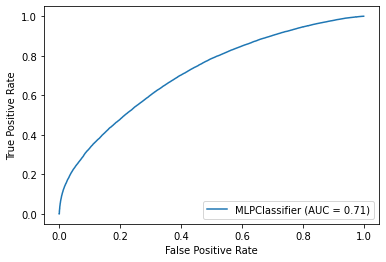

In [ ]:
from sklearn import metrics

metrics.plot_roc_curve(model, xTest, yTest)
plt.show()

In [ ]:
with open('/content/gdrive/My Drive/Notebooks Colab/logRegModel_e10.pickle', 'rb') as handle:
    model = pickle.load(handle)

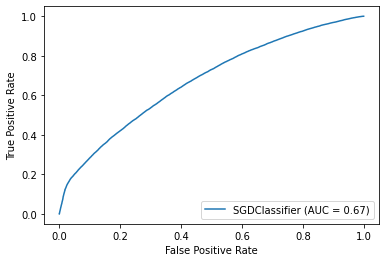

(8921483, 81)

In [ ]:
from sklearn import metrics

metrics.plot_roc_curve(model, xTest, yTest)
plt.show()
xTest.shape
X.shape